# Naive approach xgboost + optuna

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

model_name = "naive_approach_xgboost_optuna"
data_path = "./data/"
df_train = pd.read_csv(data_path + "train.csv")
df_test = pd.read_csv(data_path + "test.csv")

# drop id
df_train.drop('id', axis=1, inplace=True)

df_train['date'] = pd.to_datetime(df_train['date'])

df_train.head(10)

,date,country,store,product,num_sold
0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [2]:
def create_features(df):
    # split date into year, month, day
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day

    # week number
    df['week_number'] = df['date'].dt.isocalendar().week.astype(int)



    # day of week
    df['dayofweek'] = df['date'].dt.dayofweek

    # weekend
    df['weekend'] = (df['date'].dt.weekday >=4).astype(int)

    # drop date
    df = df.drop('date', axis=1)

    # one-hot encoding of 'country', 'store', 'product' columns
    #df_train = pd.get_dummies(df_train, columns=['country', 'store', 'product'])


    df['country'] = df['country'].astype('category')
    df['store'] = df['store'].astype('category')
    df['product'] = df['product'].astype('category')

    return df

df_train_0 = create_features(df_train)

model_features = ['country', 'store', 'product', 'year', 'month', 'day', 'week_number', 'dayofweek', 'weekend']

df_train_0.head(10)

,country,store,product,num_sold,year,month,day,week_number,dayofweek,weekend
0,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,1,52,6,1
1,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,1,52,6,1
2,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,1,52,6,1
3,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,1,52,6,1
4,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,1,52,6,1
5,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88,2017,1,1,52,6,1
6,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98,2017,1,1,52,6,1
7,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14,2017,1,1,52,6,1
8,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83,2017,1,1,52,6,1
9,Argentina,Kaggle Store,Using LLMs to Write Better,69,2017,1,1,52,6,1


In [3]:
df_train_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   country      136950 non-null  category
 1   store        136950 non-null  category
 2   product      136950 non-null  category
 3   num_sold     136950 non-null  int64   
 4   year         136950 non-null  int32   
 5   month        136950 non-null  int32   
 6   day          136950 non-null  int32   
 7   week_number  136950 non-null  int32   
 8   dayofweek    136950 non-null  int32   
 9   weekend      136950 non-null  int32   
dtypes: category(3), int32(6), int64(1)
memory usage: 4.6 MB


Function by which submissions are scored is SMAPE:

In [4]:
def SMAPE(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

In [5]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, median_absolute_error, r2_score

import xgboost as xgb
import optuna

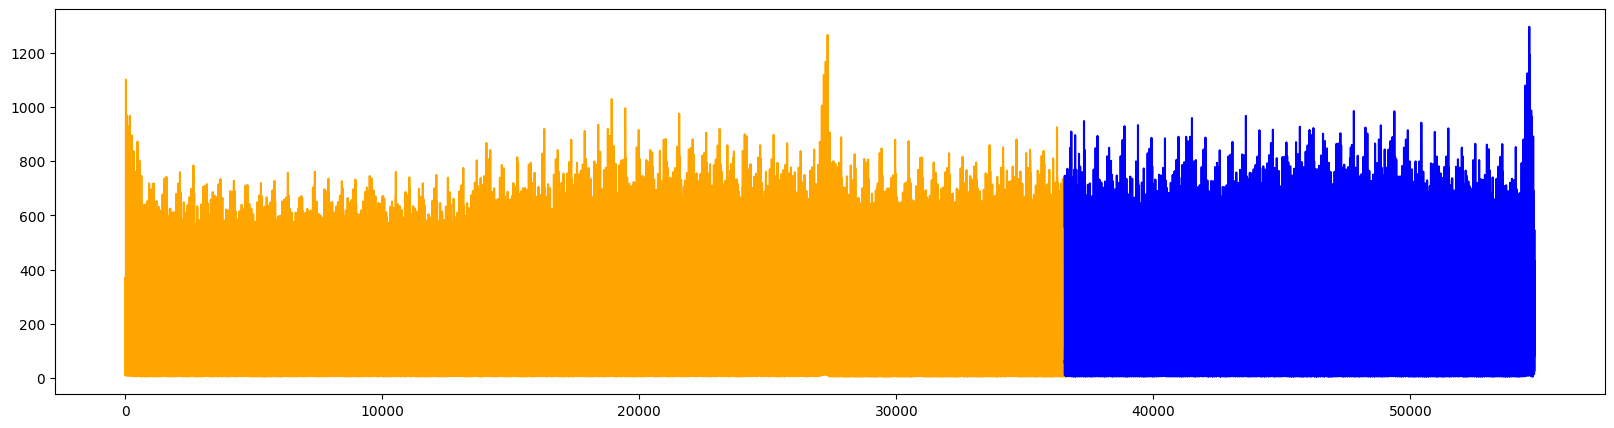

In [6]:
# get small split of data for hyperparameter tuning

train_index, val_index = [ x for x in TimeSeriesSplit(n_splits=2).split(df_train_0[ df_train_0['year'] >= 2020 ]) ][1]

X_train = df_train_0.iloc[train_index][model_features]
y_train = df_train_0.iloc[train_index]['num_sold']

X_val = df_train_0.iloc[val_index][model_features]
y_val = df_train_0.iloc[val_index]['num_sold']

# plot X_train and X_val
plt.figure(figsize=(20, 5))
plt.plot(X_train.index, y_train, color="orange", label='train')
plt.plot(X_val.index, y_val, color="blue", label='val')
plt.show()

In [7]:
def objective(trial):
    model=xgb.XGBRegressor(
        tree_method="gpu_hist", enable_categorical=True,
        n_estimators=trial.suggest_int("n_estimators", 100, 1000),
        max_depth=trial.suggest_int("max_depth", 1, 20),
        learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
    )
    
    model.fit(
        X_train, y_train,
        eval_set=[( X_train, y_train), ( X_val, y_val)],
        verbose=False
    )

    return SMAPE(y_val, np.round(model.predict(X_val)))


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_hyperparams = study.best_params

[I 2023-07-29 18:55:09,256] A new study created in memory with name: no-name-ba3e3c99-fefc-47d6-94c5-9fff5e0d095a
[I 2023-07-29 18:55:14,421] Trial 0 finished with value: 11.190882115788066 and parameters: {'n_estimators': 836, 'max_depth': 7, 'learning_rate': 0.0032677383096153634}. Best is trial 0 with value: 11.190882115788066.
[I 2023-07-29 18:55:41,015] Trial 1 finished with value: 17.469474470294283 and parameters: {'n_estimators': 809, 'max_depth': 13, 'learning_rate': 0.002395570430452216}. Best is trial 0 with value: 11.190882115788066.
[I 2023-07-29 18:58:53,837] Trial 2 finished with value: 9.731539953996265 and parameters: {'n_estimators': 265, 'max_depth': 20, 'learning_rate': 0.04705369016117513}. Best is trial 2 with value: 9.731539953996265.
[I 2023-07-29 18:59:10,168] Trial 3 finished with value: 61.42513686737877 and parameters: {'n_estimators': 649, 'max_depth': 14, 'learning_rate': 0.0011369366873190461}. Best is trial 2 with value: 9.731539953996265.
[I 2023-07-29 

In [8]:
best_hyperparams

{'n_estimators': 362, 'max_depth': 8, 'learning_rate': 0.06420308128523709}

In [9]:
# split into train and validation


results_smape = []
results_r2 = []
results_mse = []


N_SPLITS = 5

for train_index, val_index in TimeSeriesSplit(n_splits=N_SPLITS).split(df_train_0):
    X_train = df_train_0.iloc[train_index][model_features]
    y_train = df_train_0.iloc[train_index]['num_sold']

    X_val = df_train_0.iloc[val_index]
    y_val = df_train_0.iloc[val_index]['num_sold']
      
    model = xgb.XGBRegressor(tree_method="gpu_hist", enable_categorical=True, **best_hyperparams)
    model.fit(X_train, y_train)

    # evaluate on validation set
    y_pred = np.round(model.predict(X_val[model_features]))

    smape = SMAPE(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    mse = mean_squared_error(y_val, y_pred)

    results_smape.append(smape)
    results_r2.append(r2)
    results_mse.append(mse)
    del model

print("Cross validated results:")

print("SMAPE: %s" % results_smape)
print("R2: %s" % results_r2)
print("MSE: %s" % results_mse)

print("Mean results:")
print("SMAPE: %.4f" % np.mean(results_smape))
print("R2: %.4f" % np.mean(results_r2))
print("MSE: %.4f" % np.mean(results_mse))

# add a row with results to csv file leaderboard.csv

row = [model_name, np.mean(results_smape), np.mean(results_r2), np.mean(results_mse)]
with open('leaderboard.csv', 'a') as fd:
    import csv
    fd.write('\n')
    writer = csv.writer(fd, delimiter=',', lineterminator=';\n')
    writer.writerow(row)

Cross validated results:
SMAPE: [12.957020272960442, 8.272814890744744, 10.347728535893374, 13.406229525705493, 10.447989881311889]
R2: [0.965772218520227, 0.9872154370550379, 0.9709248470966305, 0.965254628542818, 0.9706731286344368]
MSE: [1206.8122234392115, 446.4960350492881, 914.7238554216867, 1097.323417305586, 1149.2704052573931]
Mean results:
SMAPE: 11.0864
R2: 0.9720
MSE: 962.9252


In [10]:
# train on full data
X_train = df_train_0.drop('num_sold', axis=1)
y_train = df_train_0['num_sold']

model = xgb.XGBRegressor(tree_method="gpu_hist", enable_categorical=True, **best_hyperparams)
model.fit(X_train[model_features], y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06420308128523709,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=362, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

C:\Users\Wiktor\AppData\Local\Temp\ipykernel_7284\4029528359.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val['date'] = pd.to_datetime(X_val['year'].astype(str) + '-' + X_val['month'].astype(str) + '-' + X_val['day'].astype(str))
C:\Users\Wiktor\AppData\Local\Temp\ipykernel_7284\4029528359.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val.sort_values(by='date', inplace=True)


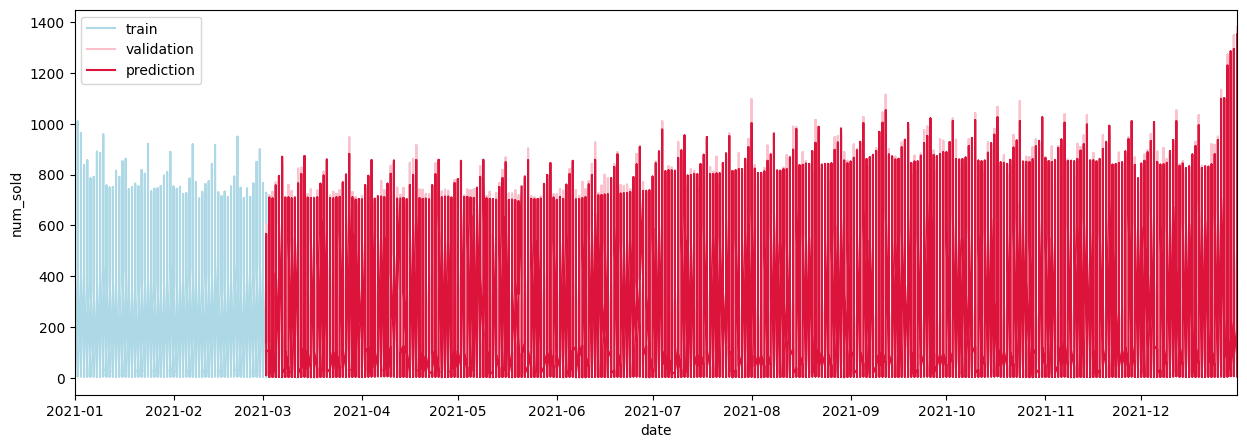

In [13]:
import datetime



X_train['date'] = pd.to_datetime(X_train['year'].astype(str) + '-' + X_train['month'].astype(str) + '-' + X_train['day'].astype(str))
X_val['date'] = pd.to_datetime(X_val['year'].astype(str) + '-' + X_val['month'].astype(str) + '-' + X_val['day'].astype(str))

df_val = X_val.copy()
df_val['actual'] = y_val
df_val['prediction'] = model.predict(df_val[model_features])
df_val['prediction'] = df_val['prediction'].astype(int)

# sort by date
X_train.sort_values(by='date', inplace=True)
X_val.sort_values(by='date', inplace=True)

# plot 'num_sold' vs 'date'
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(X_train['date'], y_train, label='train', color='lightblue')
ax.plot(X_val['date'], y_val, label='validation', color='pink')
ax.plot(df_val['date'], df_val['prediction'], label='prediction', color='crimson')

# x axis show only from 2021 onwards
ax.set_xlim([datetime.date(2021, 1, 1), df_val['date'].max()])
ax.set_xlabel('date')
ax.set_ylabel('num_sold')

ax.legend()
plt.show()

In [16]:
df_val[['date', 'actual', 'prediction']].sample(20)

,date,actual,prediction
134931,2021-12-05,53,52
115674,2021-03-23,191,192
126464,2021-08-14,107,107
114419,2021-03-06,466,416
114305,2021-03-05,36,38
134957,2021-12-05,13,14
115443,2021-03-20,144,125
135766,2021-12-16,143,141
128373,2021-09-08,77,79
129299,2021-09-20,238,246


In [14]:
# test 

df_test = pd.read_csv(data_path + "test.csv")

df_test['date'] = pd.to_datetime(df_test['date'])

df_test = create_features(df_test)
# predict for test set

df_test['prediction'] = model.predict(df_test[model_features])
df_test['prediction'] = df_test['prediction'].astype(int)
df_test

,id,country,store,product,year,month,day,week_number,dayofweek,weekend,prediction
0,136950,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,2022,1,1,52,5,1,37
1,136951,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,2022,1,1,52,5,1,37
2,136952,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,2022,1,1,52,5,1,6
3,136953,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,2022,1,1,52,5,1,37
4,136954,Argentina,Kaggle Learn,Using LLMs to Write Better,2022,1,1,52,5,1,29
...,...,...,...,...,...,...,...,...,...,...,...
27370,164320,Spain,Kagglazon,Using LLMs to Improve Your Coding,2022,12,31,52,5,1,741
27371,164321,Spain,Kagglazon,Using LLMs to Train More LLMs,2022,12,31,52,5,1,749
27372,164322,Spain,Kagglazon,Using LLMs to Win Friends and Influence People,2022,12,31,52,5,1,115
27373,164323,Spain,Kagglazon,Using LLMs to Win More Kaggle Competitions,2022,12,31,52,5,1,662


In [15]:
df_test['num_sold'] = df_test['prediction']
df_test[['id', 'num_sold']].to_csv(f'{model_name}_submission.csv', index=False)

In [17]:
model_name

'naive_approach_xgboost_optuna'

In [18]:
! kaggle competitions submit -c playground-series-s3e19 -f naive_approach_xgboost_optuna_submission.csv -m "naive_approach_xgboost_optuna"

Successfully submitted to Forecasting Mini-Course Sales



  0%|          | 0.00/308k [00:00<?, ?B/s]
 26%|██▌       | 80.0k/308k [00:00<00:00, 783kB/s]
100%|██████████| 308k/308k [00:01<00:00, 255kB/s] 
